In [1]:
import pysr

In [2]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
from lib.data import prepare_nuclear_data
from lib.utils import  PlottingContext, IO, get_rms
from argparse import Namespace

In [3]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')

In [104]:
feats = np.load('features/all_0_all_data_200k_features.npy')
phy_terms = np.load('features/physics_terms.npy')
zn = np.load('features/zn.npy')
BE = np.load('./features/BE.npy')

In [44]:
# load args from disk
task = "binding_semf"
args = {
    "DEPTH": 2,
    "DEV": (device:="cpu"),
    "EPOCHS": 20_000,
    "HIDDEN_DIM": 2048,
    "LR": 0.0001,
    "MODEL": "baseline",
    "SIGMOID_READOUT": "false",
    "TMS": "remove",
    "WD": 0.01,
    "DEV": "cpu",
    "TARGETS_CLASSIFICATION": {},
    "TARGETS_REGRESSION": {f"{task}": 100,
    #  "radius": 0.01
     },

    "TRAIN_FRAC": 1,
    "LIPSCHITZ": "false",
    "TRAIN_SET": "all_data", # random, all_data, extrap_1, extrap_2, extrap_3
    "BATCH_SIZE": 1024,
    "LOG_TIMES": 10,
    "NUCLEI_GE": 0,
    "NUCLEI_HIGH_UNC": "keep",
    "PER_NUCLEON": "true",
    "SEED": 0,
}

args = Namespace(**args)

# IO.save_args(args, f"experiments/{experiment_name}/args.yaml")

data = prepare_nuclear_data(args)

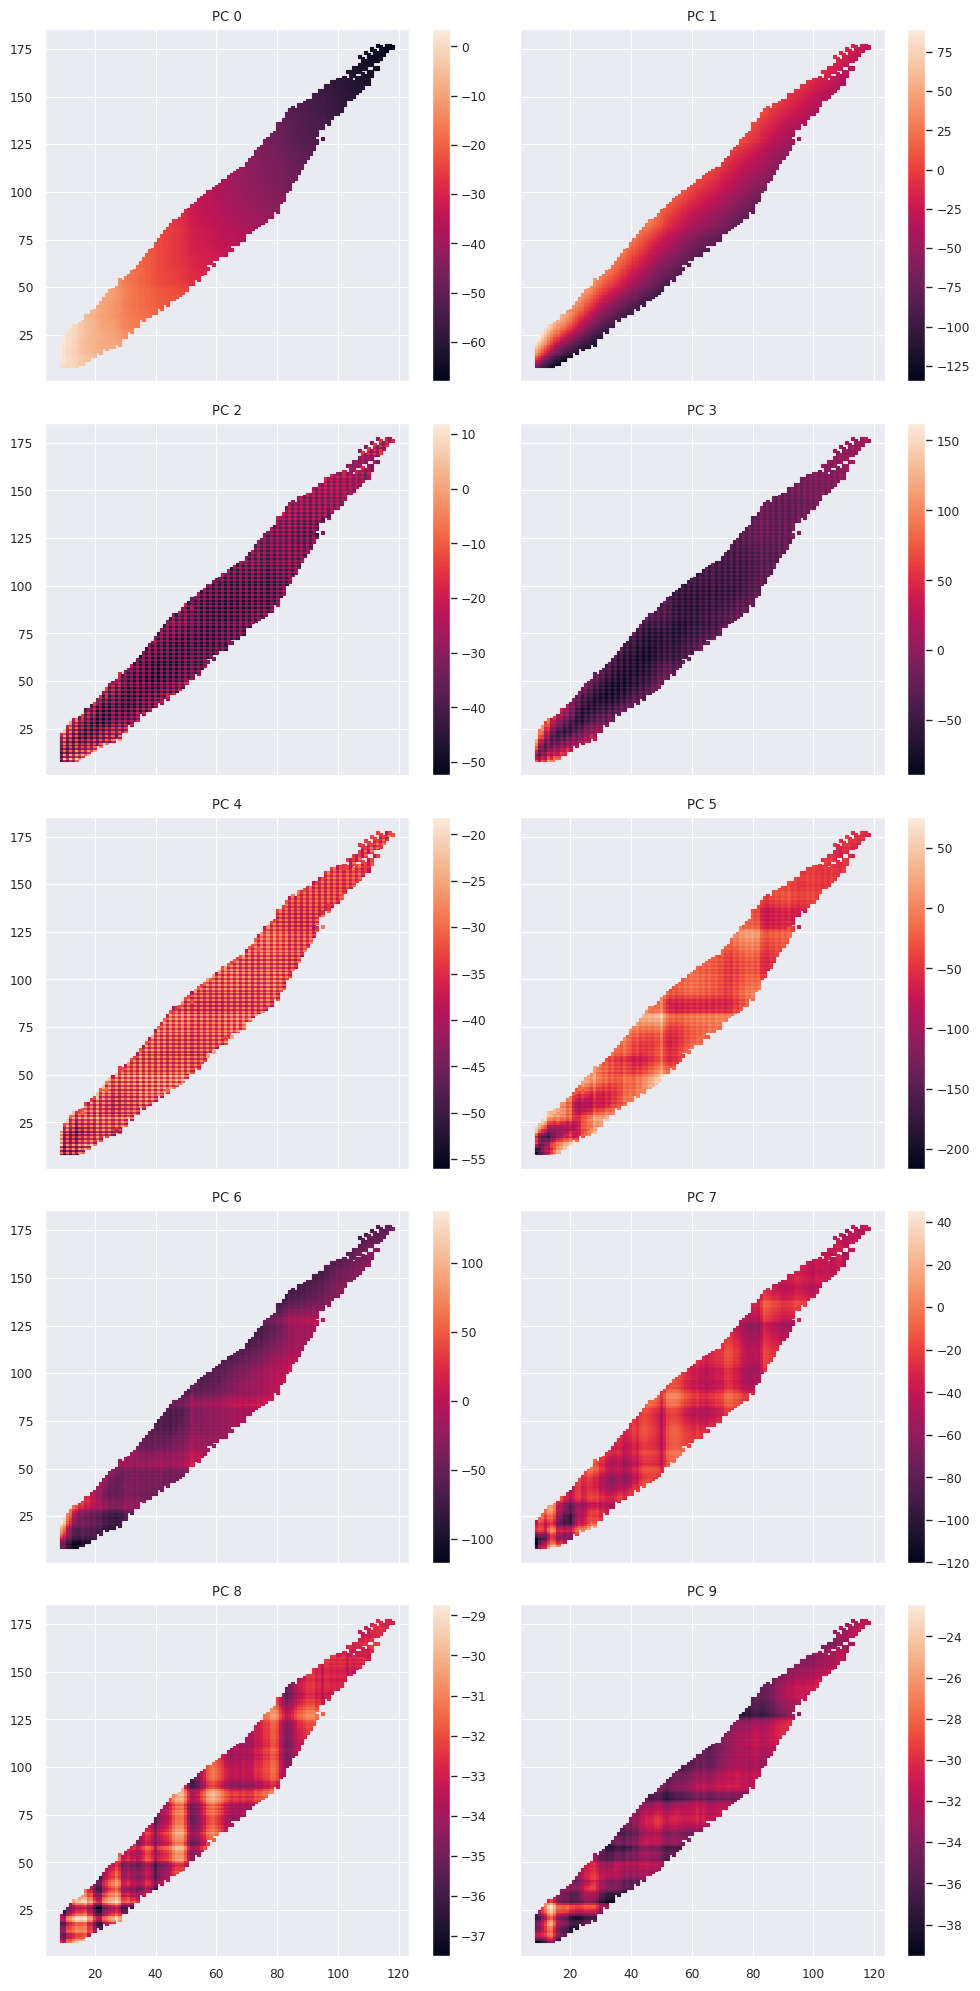

In [6]:
num_plots = min(feats.shape[0], 10)
fig, axes = plt.subplots(max(num_plots//2, 1), 2, figsize=(10, 2 * num_plots), sharex=True, sharey=True)
axes = axes.flatten()
Z, N = zn[:, 0], zn[:, 1]

features = feats
for i in range(10):
    ax = axes.flatten()[i]
    sc = ax.scatter(Z, N, c=features[i], s=5, marker='s')
    ax.set_title(f"PC {i}")
    fig.colorbar(sc, ax=ax)
fig.tight_layout()

/mnt/d/workspace/NuCLR-MechInterp/lib/utils.py:221: RuntimeWarning: invalid value encountered in divide
  P = nup * nun / (nup + nun)


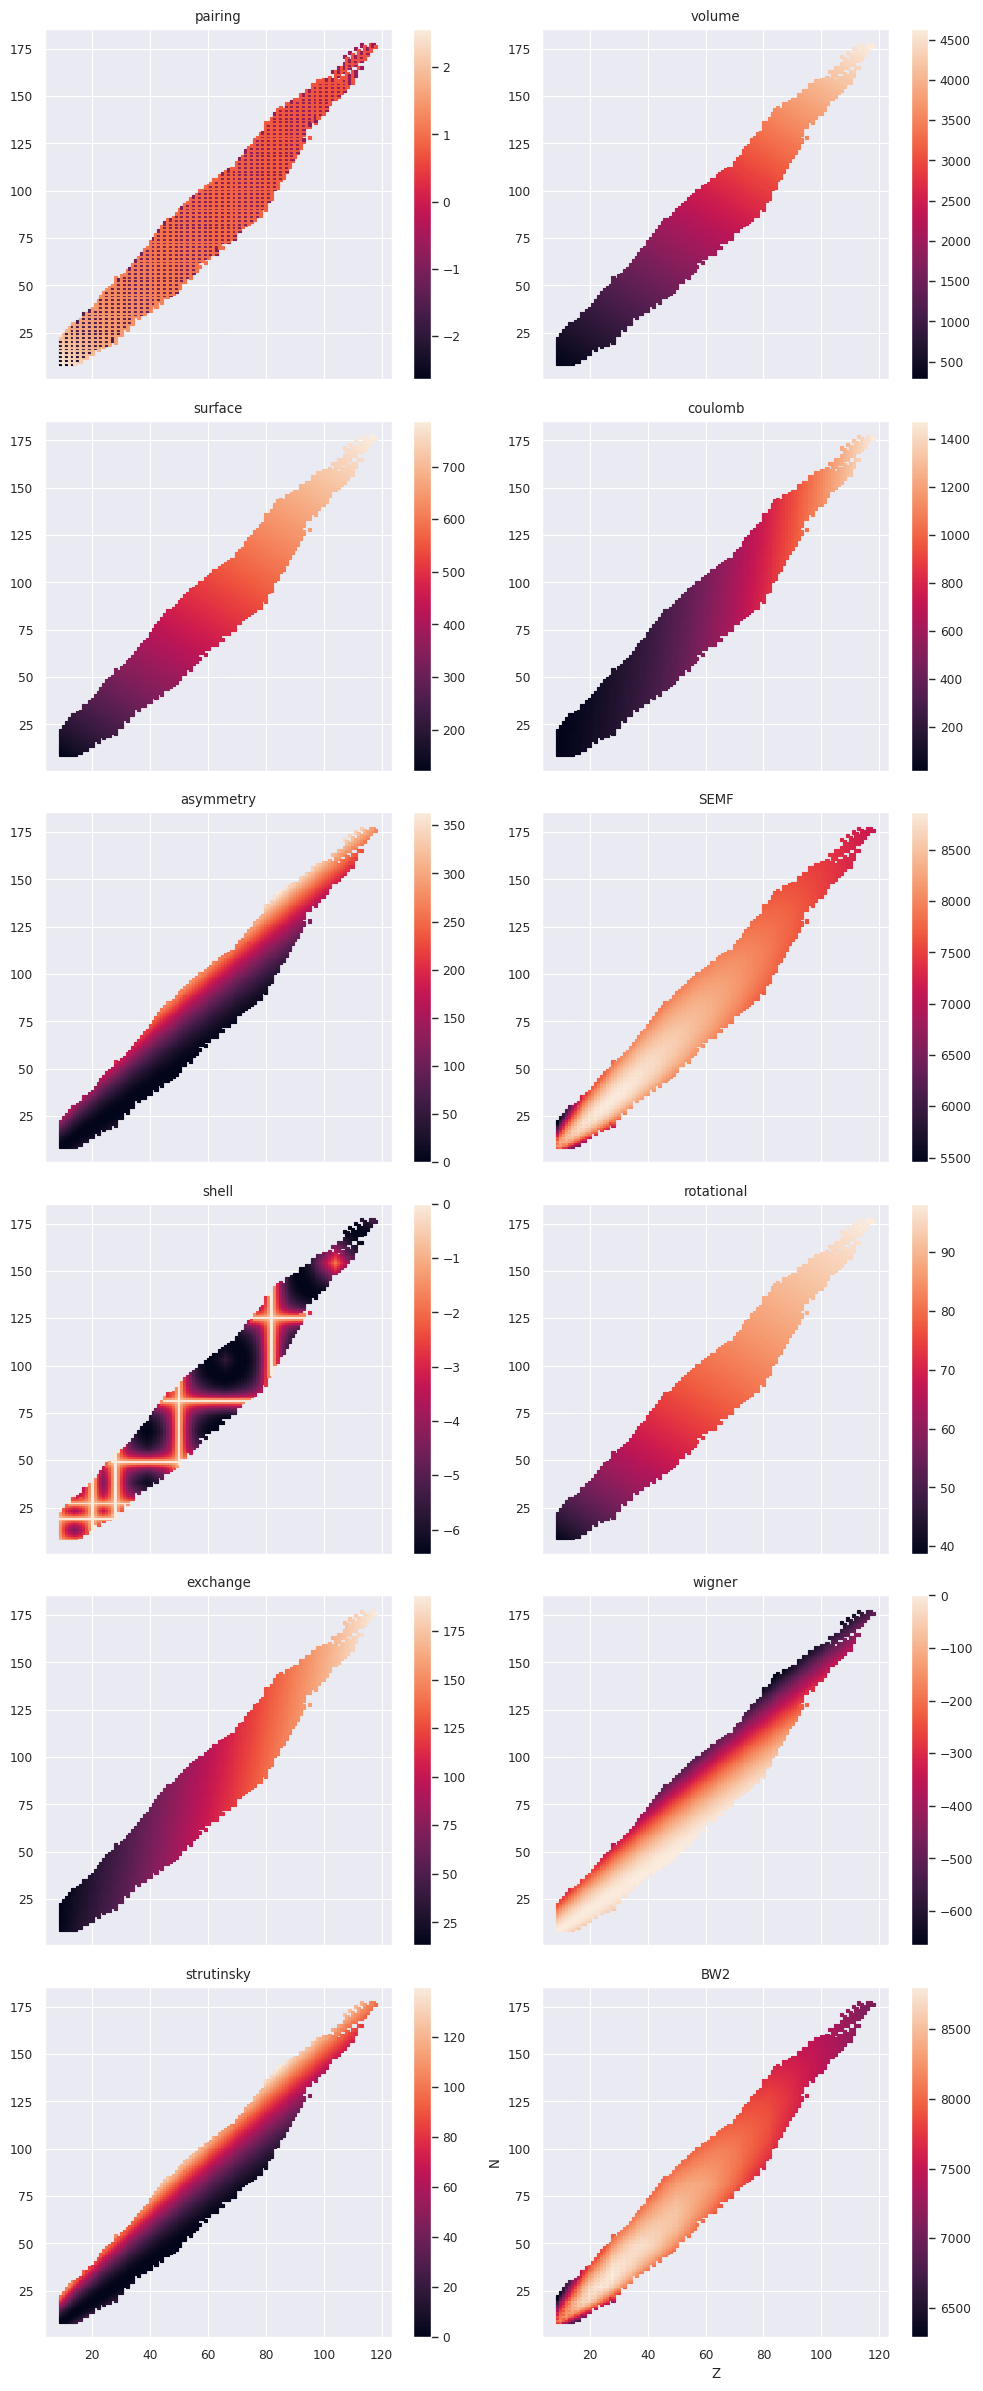

In [7]:
from lib.utils import Physics

terms = [getattr(Physics, func) for func in Physics.all_funcs]


fig, axes = plt.subplots(len(terms)//2, 2, figsize=(10, 2 * len(terms)), sharex=True)
for i, term in enumerate(terms):
    ax = axes.flatten()[i]
    sc = ax.scatter(Z, N, c=term(Z, N), s=5, marker='s')
    ax.set_title(term.__name__)
    fig.colorbar(sc, ax=ax)
ax.set_xlabel("Z")
ax.set_ylabel("N")
plt.tight_layout()
plt.show()

In [13]:
# For PC2
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    early_stop_condition=(
    "stop_if(loss, complexity) = loss < 1e-6 && complexity < 10"
    # Stop early if we find a good and simple equation
    ),
)

# Learn equations
pc2_model = PySRRegressor(
    niterations=30,
    binary_operators=["plus", "mult", "pow"],
    unary_operators=["cos", "sin", "isev(x) = ((abs(x) % 2) == 0) * one(x)"],
    extra_sympy_mappings={"isev": lambda x: sympy.Piecewise((1.0, sympy.Eq(sympy.Mod(x, 2), 0)), (0, True))},
    constraints={"pow": (3, 3)},
    nested_constraints={"sin": {"sin": 0, "cos": 0}, "cos": {"sin": 0, "cos": 0}},
    **default_pysr_params
)

In [99]:
#pc2_model.fit(zn, features[2])

In [8]:
pc0_model = PySRRegressor.from_file('./fits/pc0/hall_of_fame_2023-12-22_204024.702.pkl')
pc1_model = PySRRegressor.from_file('./fits/pc1/hall_of_fame_2023-12-23_222425.715.pkl')
#pc2_model = PySRRegressor.from_file('./hall_of_fame_2024-01-04_233617.061.pkl')

Checking if ./fits/pc0/hall_of_fame_2023-12-22_204024.702.pkl exists...
Loading model from ./fits/pc0/hall_of_fame_2023-12-22_204024.702.pkl
Checking if ./fits/pc1/hall_of_fame_2023-12-23_222425.715.pkl exists...
Loading model from ./fits/pc1/hall_of_fame_2023-12-23_222425.715.pkl


In [11]:
model = pc0_model
pc_number = 0

In [9]:
#model.set_params(extra_sympy_mappings={"isev": lambda x: sympy.Piecewise((1.0, sympy.Eq(sympy.Mod(x, 2), 0)), (0, True))})
#model.set_params(extra_sympy_mappings={"even": lambda x: x % 2})
#model.refresh()

Default selection RMSE: 0.8827527560200653


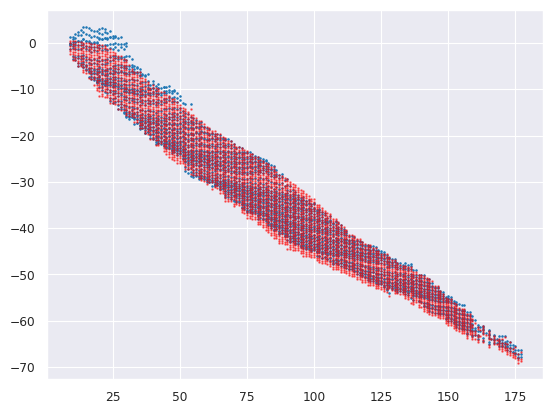

In [12]:
print("Default selection RMSE:", (np.power(model.predict(zn) - features[pc_number], 2).mean())**0.5)
plt.scatter(N, feats[pc_number,:], s=1)
plt.scatter(N, model.predict(zn), s=1, c='red', alpha=0.5)

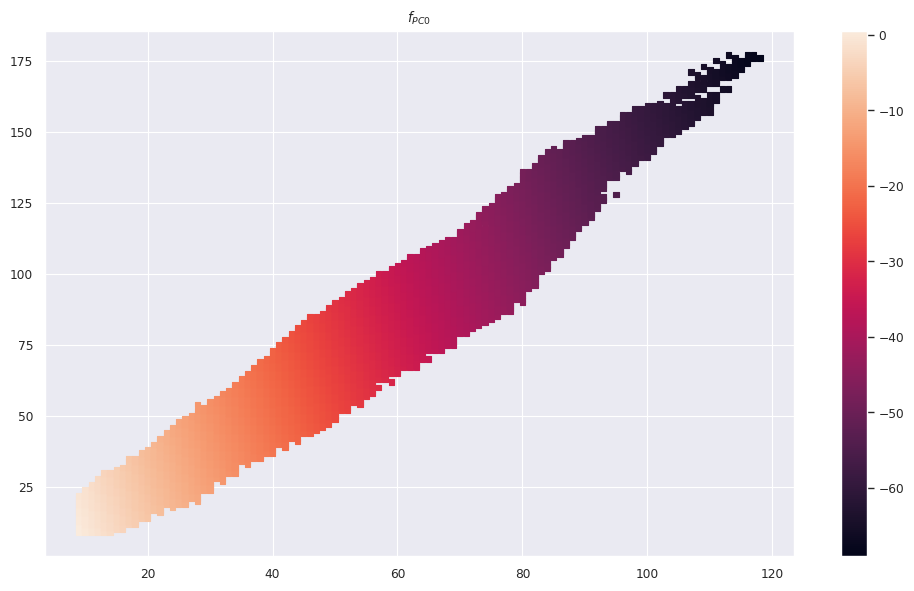

In [13]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(Z, N, c=model.predict(zn), s=15, marker='s')
plt.title(r"$f_{{PC0}}$") # Replace with your desired title
plt.colorbar(sc)
plt.tight_layout()
plt.show()

In [54]:
preds_model = model.predict(zn) # + preds

In [15]:
# Assuming data.X[:,:2].numpy() and zn are numpy arrays with two columns but possibly different row counts
X = data.X[:,:2].numpy()  # Extracting the relevant part of data.X
# zn is assumed to be already defined

# Convert arrays to structured arrays with the same dtype
dtype = [('col1', X.dtype), ('col2', X.dtype)]
X_struct = np.array(list(map(tuple, X)), dtype=dtype)
zn_struct = np.array(list(map(tuple, zn)), dtype=dtype)

# Use numpy's in1d to find matching rows
matches = np.in1d(X_struct, zn_struct)

# Apply the matches to y
y_matched = data.y[matches]

In [105]:
from lib.data import semi_empirical_mass_formula

transformed_targets = False
X_matched = data.X[matches]
semf_data = semi_empirical_mass_formula(X_matched[:,0], X_matched[:,1])

if transformed_targets:
    data_BE = BE #data.regression_transformer.inverse_transform(y_matched).squeeze() + semf_data.numpy()
    data_semf_res = data.regression_transformer.inverse_transform(y_matched).squeeze()
else:
    data_BE = BE #y_matched.squeeze() + semf_data.numpy()
    data_semf_res = y_matched.squeeze() 

In [106]:
data_semf_res.shape

torch.Size([3227])

In [107]:
semf_data

tensor([7726.4429, 8003.9761, 7887.4624,  ..., 7150.4673, 7147.6626,
        7131.7031])

In [108]:
pc_from_model = model.predict(X_matched[:,:2])

In [109]:
# prompt: linear regression for X_from_model to y=data_semf

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(pc_from_model.reshape(-1, 1), data_semf_res)

data_semf_res_from_reg = linreg.predict(pc_from_model.reshape(-1, 1))

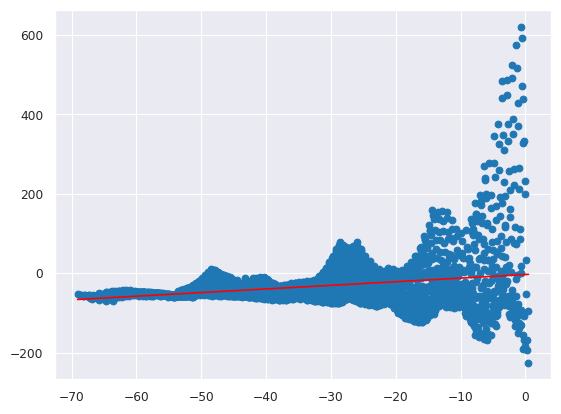

In [111]:
plt.scatter(pc_from_model.reshape(-1, 1), data_semf_res)
plt.plot(pc_from_model.reshape(-1, 1), data_semf_res_from_reg, c='red')

In [112]:
preds_reg_pc_fitted_semf = semf_data.numpy() + data_semf_res_from_reg

In [113]:
data_semf_res_from_reg

array([ -2.54664077,  -2.62451973,  -2.70239868, ..., -65.43075125,
       -65.50863021, -65.87337877])

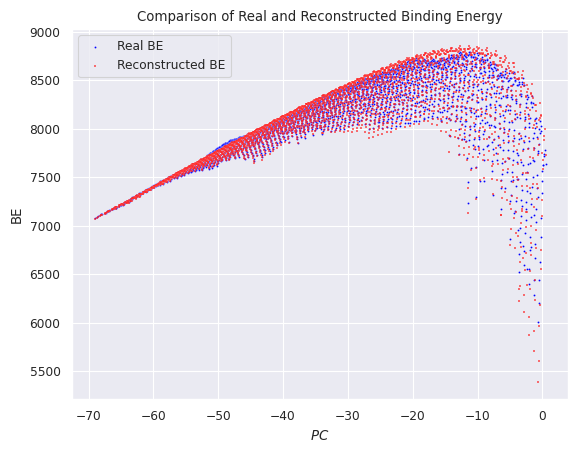

In [114]:
# Create a scatter plot for the real BE
sns.scatterplot(x=pc_from_model.reshape(-1, 1).flatten(), y=data_BE,
                s=2, color='blue', label='Real BE')

# Create a scatter plot for the reconstructed BE
sns.scatterplot(x=pc_from_model.reshape(-1, 1).flatten(), y=preds_reg_pc_fitted_semf,
                alpha=0.6, s=2, marker='s', color='red', label='Reconstructed BE')

# Labeling axes
plt.xlabel(rf'$PC$')  # Replace model.latex() with the actual function call
plt.ylabel('BE')

# Adding a legend and title
plt.legend()
plt.title('Comparison of Real and Reconstructed Binding Energy')

# Show the plot
plt.show()

In [116]:
rms_reg_semf = get_rms(preds_reg_pc_fitted_semf, data_BE, X_matched[:,:2].numpy(), scale_by_A=True)

In [117]:
rms_reg_semf

4008.8339419852255

In [118]:
print("SEMF rms:", np.mean(((semf_data.numpy() - data_BE)*A)**2)**0.5)

SEMF rms: 7771.936233354249


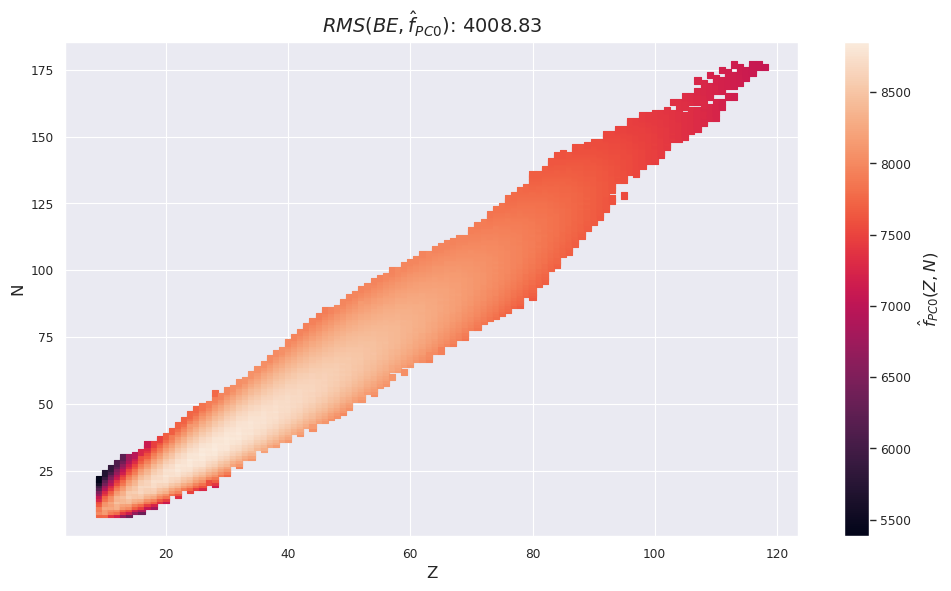

In [119]:
plt.figure(figsize=(10, 6))

# Scatter plot
sc = plt.scatter(X_matched[:,0], X_matched[:,1], c=preds_reg_pc_fitted_semf, s=20, marker='s')

# Enhancing the title
plt.title(fr"$RMS(BE, \hat{{f}}_{{PC{pc_number}}})$: {round(rms_reg_semf, 2)}", fontsize=14)

# Adding axis labels with increased font size
plt.xlabel('Z', fontsize=12)
plt.ylabel('N', fontsize=12)

# Colorbar with label
cbar = plt.colorbar(sc)
cbar.set_label(fr"$\hat{{f}}_{{PC{pc_number}}}(Z,N)$", fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig(f"plots/f_pc{pc_number}.pdf")

In [120]:
sympy_final_func = (model.sympy() * linreg.coef_) + linreg.intercept_

In [81]:
model.latex()

'- 0.509 x_{0} - 0.0855 x_{1} + e^{\\cos{\\left(0.0520 x_{0} \\right)}} + 3.40'

In [122]:
def closed_form_linear_regression(X, y):
    X = np.array(X)
    y = np.array(y)

    X_b = np.c_[np.ones((len(X), 1)), X]

    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    # theta_best contains [b, a]
    b = theta_best[0]
    a = theta_best[1]

    return a, b

In [123]:
closed_form_linear_regression(pc_from_model.reshape(-1, 1), data_semf_res)

(0.9104525660243434, -2.9854916318491203)